In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

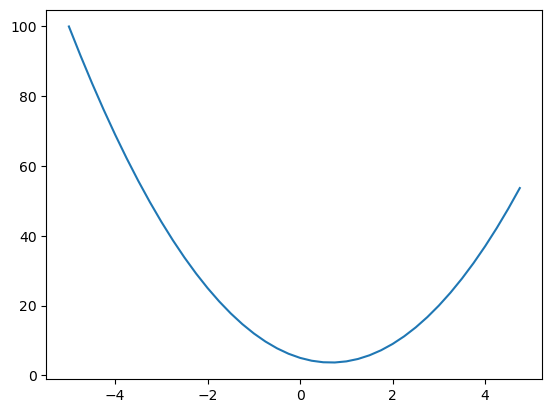

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = 2/3
slope = (f(x + h) - f(x)) / h
slope # at 3.0, slope is 14.0

0.0002999999981767587

In [6]:
# more complex case
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)
# d2 - d1 represents the amount d changed when a was increased by h. Normalized on h


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [44]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0 # no effect on the output value.
        self._backward = lambda: None
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # so that we can add ints/floats to Values w/o needing to convert them on our own
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            return
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad # local deriv. * global deriv.
            other.grad += self.data * out.grad
            return
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # only supporting ints/floats for now
        out = Value(self.data ** other, (self, ), label=f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            return
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # local deriv. * global deriv.
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # local deriv. * global deriv.
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [45]:
from graphviz import Digraph

"""First off...methods within methods is dope as hell
Second off, this method calls build() on root, the starting node of the graph.
Add the root to this nodes list, and add its children to the edges.
Then repeat for the children. So at the end you have this tree structure.
"""
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # Create an op node for our operations
            dot.node(name = uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')

x1w1=x1*w1;x1w1.label = 'x1*w1'
x2w2=x2*w2;x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'

o.backward()

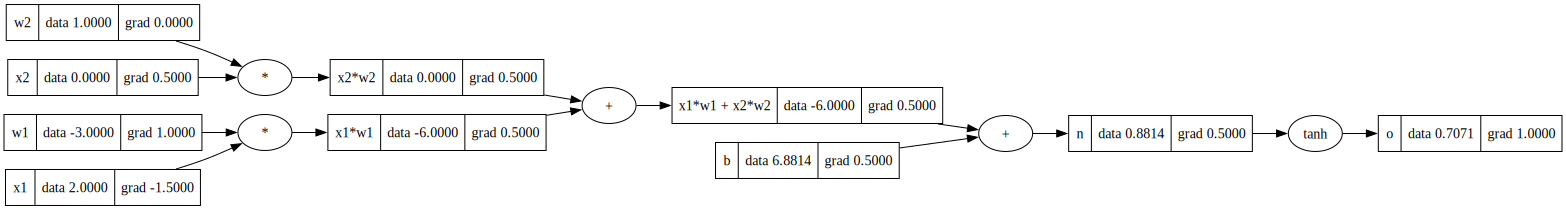

In [ ]:
draw_dot(o)

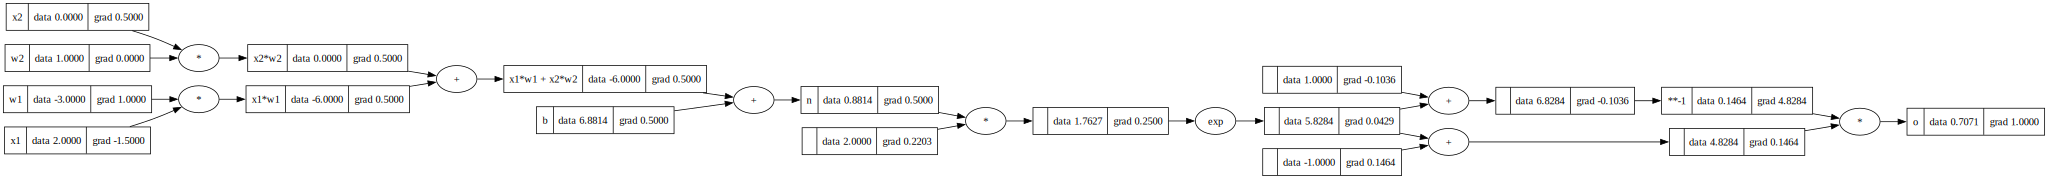

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')

x1w1=x1*w1;x1w1.label = 'x1*w1'
x2w2=x2*w2;x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
#-----
e = (2 * n).exp()
o = (e - 1) / (e + 1)
#-----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n) # return object is a tensor

print(o.data.item()) # takes a single tensor of one element, returns that element (strips the tensor)
o.backward()

print("---")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# It's being cast to a double so we have the same level of precision in the 
# floats as in Python. WOW!

# tensors are normally float32, but double() makes it float64. 
# all the leaf nodes to be set to have gradients. 
"""
See normally we wouldn't want gradients for leaf nodes...because they're leaves,
meaning they're usually inputs. But in this case we want to see them, so we have 
to set it to True (default is False). 

Pytorch is more efficient b.c. you can do operations on multiple tensors 
at once, and tensors can be super long.

Lol it's like he said. MicroGrad is the core of ML, and everything else is just efficiency.
"""

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


"\nSee normally we wouldn't want gradients for leaf nodes...because they're leaves,\nmeaning they're usually inputs. But in this case we want to see them, so we have \nto set it to True (default is False). \n"

## building a neural net library in micrograd

In [46]:
# Will subscribe to the Pytorch API in how it works...kinda
import random
class Neuron:
    # each neuron has nin inputs to it, each needs to have an initial weight
    # Each neuron also has a bias term into it (a +1 term) which also has a weight :)))))
    def __init__(self, nin): # nin - number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # zip concatenates the elements of each input side by side and returns them as tuples!
        # e.g zip([1, 2], [3, 4]) = [(1, 3), (2, 4)]
        # then the list comprehension will perform the dot product and add the bias term
        
        # original way of doing it
        # act = sum(wi*xi for wi,xi in zip(self.w, x)) + self.b


        # WE CAN MAKE THIS MORE FUCKING EFFICIENT!!!
        # sum accepts a starting value as an arg. Normally it's zero, but we can just make it SELF.B!
        # I FUCKING LOVE THIS GUY
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    """
    Defines a layer of neurons. A layer of neurons is nothing but a list
    of neurons each evaluated independently. 

    nout is number of neurons in the layer. How many outputs should the layer have?
    """
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        # a layer of neurons 
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    """
    nouts is a list defining all the sizes of each layer that we want. 
    So each layer has inputs going into it, and outputs. The outputs of 
    one layer become the inputs to the next layer. 

    Then for each layer, we do the forward pass, which is just doing the forward
    pass for each neuron in each layer (b.c. they're all evaluated independently of
    one another). 

    We have to update x each time because the output changes with each layer.
    x is originally the inputs, then it's the output of layer 1...and so on.
    """
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [87]:
"""
The way __call__ works is we can define a set of inputs x
, then make a neuron with 2 inputs, and then call n on x,
and it should return w * x + b. WOW!
"""
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9630050744226498)

## now we add a small dataset and loss function

In [88]:
xs = [
    [2.0, 3.0, -1.0],   # desired = 1.0
    [3.0, -1.0, 0.5],   # desired = -1.0
    [0.5, 1.0, 1.0],    # desired = -1.0
    [1.0, 1.0, -1.0],   # desired = 1.0
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [114]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 0.0007998629922354906
1 0.0007973599521239635
2 0.0007948726077654218
3 0.0007924008119189806
4 0.0007899444191788079
5 0.0007875032859456602
6 0.0007850772703989209
7 0.0007826662324691381
8 0.0007802700338111308
9 0.0007778885377775666
10 0.0007755216093929818
11 0.0007731691153282934
12 0.0007708309238758333
13 0.0007685069049247772
14 0.0007661969299369942
15 0.0007639008719234399
16 0.0007616186054208286
17 0.0007593500064688781
18 0.0007570949525878151
19 0.0007548533227563982


In [115]:
ypred

[Value(data=0.9921018116546205),
 Value(data=-0.9860006067236391),
 Value(data=-0.9808969232435212),
 Value(data=0.9885299786422531)]